<a href="https://colab.research.google.com/github/Jonathan-Brito/processamento-linguagem-natural/blob/main/Projeto_1_Classifica%C3%A7%C3%A3o_de_Sentimentos_com_Redes_Neurais_Convolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1: Importação das bibliotecas

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [ ]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [ ]:
train_data.shape

(1600000, 6)

In [ ]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train_data.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
train_data.sentiment.unique()

array([0, 4])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


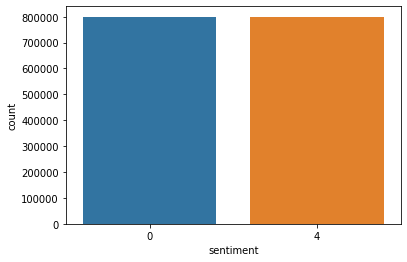

In [ ]:
sns.countplot(train_data.sentiment);

In [ ]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

In [ ]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
test_data.shape

(498, 6)

In [ ]:
test_data.sentiment.unique()

array([4, 0, 2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


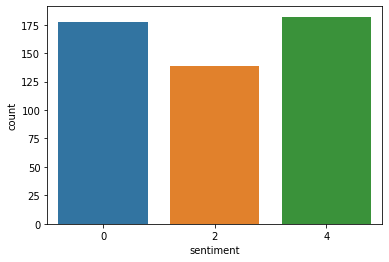

In [ ]:
sns.countplot(test_data.sentiment);

## Pré-processamento

### Limpeza

In [ ]:
data = train_data

In [ ]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [ ]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
X = data.iloc[:, 1].values

In [ ]:
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [ ]:
X.shape

(1600000,)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
y = data.iloc[:, 0].values
y

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [ ]:
X.shape

(240000,)

In [ ]:
y.shape

(240000,)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [ ]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [ ]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
text = clean_tweets(text)
text

' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [ ]:
nlp = sp.load('en')
nlp

In [ ]:
stop_words = sp.lang.en.STOP_WORDS

In [ ]:
print(stop_words)

{'else', 'those', 'most', 'your', 'thereby', 'neither', 'every', 'full', 'latter', 'further', 'too', 'had', 'whereas', 'any', 'ever', 'quite', 'both', 'which', 'become', 'while', 'sometimes', 'below', 'will', 'seem', 'until', 'him', 'before', 'whoever', 'never', 'have', "'ve", 'between', 'only', 'otherwise', 'than', 'throughout', 'our', 'though', 'across', 'onto', 'whose', 'were', 'via', '’re', '’m', 'also', 'none', 'thence', 'seems', 'an', 'whereupon', 'call', 'whole', 'sixty', 'other', 'same', 'whereby', 'to', 'hers', 'elsewhere', 'mine', 'although', 'itself', 'back', 'its', 'over', '’ll', 'anywhere', 'thru', 'afterwards', 'noone', 'now', 'among', 'this', 'forty', 'from', 'whether', 'some', 'perhaps', 'ours', 'fifteen', 'may', 'nowhere', 'that', 'whereafter', 'we', 'thus', 'beside', 'against', 'twelve', "n't", 'did', 'front', 'yet', 'around', 'not', '‘ve', 'get', 'sometime', '’ve', 'well', 'toward', 'since', 'alone', 'therein', 'except', 'together', 'six', 'because', 'less', 'whence'

In [ ]:
len(stop_words)

326

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
# Awww that's a bummer. You shoulda got David Carr of Third Day to do it. D"

In [ ]:
text2 = clean_tweets2(text)
text2

'  awww s bummer shoulda got david carr day d'

In [ ]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

In [ ]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

  nice situated pictures bandwidth blog awesome
wants lsgh batchmates wah ... better ... ...
ugh woke late today pm yoga class wanted lunch marais tomorrow guess ... crepe gb
  know
spx trading systems cost course teaches equations analysis
sure blog link right profile
  tweets know love duh u bff
omg passed psychic spotted yesssss
sorta makes sad main reason tanking pet solo chillmaw
  liked seafood better half tho


In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 4] = 1

In [ ]:
data_labels

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
np.unique(data_labels)

array([0, 1])

### Tokenização

In [ ]:
2**16

65536

In [ ]:
import math
math.pow(2, 16)

65536.0

In [ ]:
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [ ]:
tokenizer.vocab_size

52978

In [ ]:
print(tokenizer.subwords)

['  ', 's_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'u_', 'don_', ' ...', 'work_', 'today_', 'time_', 'know_', 'new_', 'll_', 'want_', 'think_', 'oh_', 'lol_', 'need_', 'night_', 'thanks_', 'hope_', 'home_', 've_', 'great_', 'miss_', 'feel_', ' .... ', 'd_', 'twitter_', 'day', 'na_', 'morning_', 'wish_', 'lol', 'gon_', 'getting_', 'happy_', 'today', 'bad_', 'haha_', 'tomorrow_', 'watching_', ' ..', 'sorry_', 'way_', 'come_', 'nice_', 'didn_', 'yeah_', 'sad_', 'fun_', 'sleep_', 'work', 'n_', 'wait_', 'hey_', 'hate_', 'right_', 'people_', 'better_', 'bed_', 'yes_', 'tonight_', 'little_', 'school_', 'y_', 'wanna_', 'having_', 'week_', 'long_', 'best_', 'days_', 'won_', 'let_', 'thank_', 'watch_', 'time', 'awesome_', 'working_', 'sure_', 'feeling_', 'ready_', 'r_', 'e_', 'tomorrow', 'ok_', 'ur_', 'good', 'looking_', 'o_', 'went_', 'night', 'find_', 'weekend_', 'man_', 'look_', 'tired_', 'trying_', 'thing_', 'life_', 'maybe_', 'pretty_', 'w_

In [ ]:
ids = tokenizer.encode('i am happy')
ids

[282, 5123, 362]

In [ ]:
text = tokenizer.decode(ids)
text

'i am happy'

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[1, 192]
[48681, 7335, 1182, 9304, 23461, 5859, 4216, 1907, 381]
[9, 31, 62]
[327, 79, 19, 12, 148, 298, 382, 4258, 3164, 11, 4652, 14169]
[1, 171]
[671, 2, 19, 2135, 37111, 15, 52838, 242, 32, 1453, 10390, 16]
[233, 625, 11092, 490, 272, 10998, 10432, 7466]
[414, 6050, 38588, 1111, 19317, 2137, 737, 1483, 962, 4751]
[49850, 2, 146, 103, 261]
[1, 1119, 409, 1202, 4628, 1671, 1796, 37, 534, 3901]


### Padding

In [ ]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

59

In [ ]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[    1    30    96   162   395    17   143    14 11713     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0]
[1936    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[    1    49  5126    11    31  4911  1023    40 24286   851   851 43808
   134     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     

### Divisão da base de dados em treinamento e teste



In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [ ]:
train_inputs[0]

array([    1, 33570,  5119,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
train_inputs.shape

(168000, 59)

In [ ]:
train_labels.shape

(168000,)

In [ ]:
test_inputs.shape

(72000, 59)

In [ ]:
test_labels.shape

(72000,)

# Etapa 3: Construção do modelo

In [ ]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Etapa 4: Treinamento

## Configuração dos parâmetros

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

52978

In [ ]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [ ]:
dropout_rate = 0.2
nb_epochs = 5

## Treinamento

In [ ]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [ ]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Train on 151200 samples, validate on 16800 samples
Epoch 1/5
151200/151200 [==============================] - 597s 4ms/sample - loss: 0.5030 - accuracy: 0.7511 - val_loss: 0.4745 - val_accuracy: 0.7713
Epoch 2/5
151200/151200 [==============================] - 597s 4ms/sample - loss: 0.3616 - accuracy: 0.8393 - val_loss: 0.5096 - val_accuracy: 0.7618
Epoch 3/5
151200/151200 [==============================] - 597s 4ms/sample - loss: 0.1884 - accuracy: 0.9221 - val_loss: 0.6882 - val_accuracy: 0.7420
Epoch 4/5
151200/151200 [==============================] - 598s 4ms/sample - loss: 0.1003 - accuracy: 0.9588 - val_loss: 1.0515 - val_accuracy: 0.7409
Epoch 5/5
151200/151200 [==============================] - 598s 4ms/sample - loss: 0.0686 - accuracy: 0.9710 - val_loss: 1.2108 - val_accuracy: 0.7337


'./ckpt-2'

# Etapa 5: Avaliação do modelo

## Avaliação

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

72000/72000 [==============================] - 41s 573us/sample - loss: 1.4247 - accuracy: 0.7326
[1.4246830334266027, 0.73255557]


In [ ]:
y_pred_test = Dcnn.predict(test_inputs)

In [ ]:
y_pred_test

array([[9.9197501e-01],
       [3.6060758e-04],
       [9.5440316e-01],
       ...,
       [2.2637157e-01],
       [9.9972755e-01],
       [2.0408092e-04]], dtype=float32)

In [ ]:
y_pred_test = (y_pred_test > 0.5)

In [ ]:
y_pred_test

array([[ True],
       [False],
       [ True],
       ...,
       [False],
       [ True],
       [False]])

In [ ]:
test_labels

array([1, 0, 0, ..., 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[26647,  9353],
       [ 9903, 26097]])

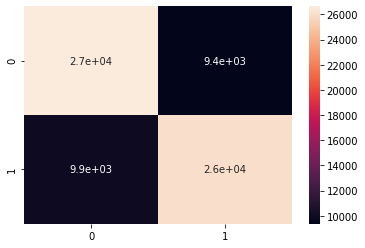

In [ ]:
sns.heatmap(cm, annot=True)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

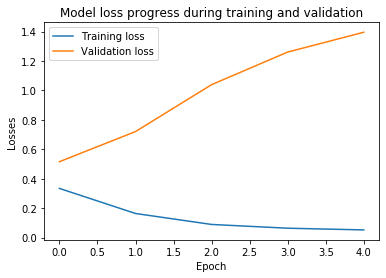

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

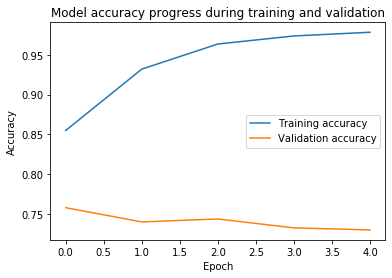

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [ ]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[282, 66, 3434]

In [ ]:
Dcnn(np.array([text]), training=False).numpy()

array([[2.1656092e-06]], dtype=float32)